In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels

In [2]:
import urllib
params ='DRIVER={SQL Server};SERVER=CL-AMILAH\AMILA;DATABASE=GSH;UID=Amila;Trusted_Connection=yes;'       
params = urllib.parse.quote_plus(params)

from sqlalchemy import create_engine
db = create_engine('mssql+pyodbc:///?odbc_connect=%s' % params)

In [3]:
sql = '''
SELECT inv.[ID] ,inv.SiteUID, [Date] , [OutletUID] ,ot.Name AS outlet ,pr.Description AS province , di.Description AS district 
, ar.Description AS Area , inv.[AgentUID] ,Concat(emp.FirstName ,' ' , emp.MiddleInitials , ' ', emp.LastName ) AS AgentName , inv.[DistributorUID] , d.Name AS distributor, [ItemUID] ,it.Description AS item, [UnitQty] 
, [UnitPrice] , [RetailUnitPrice] , [FreeQty] , [FreeCompanyQty] , [GrossValue]
,datename(YEAR, Date) AS Year
,datename(month, Date) AS MonthName
,MONTH(Date) AS Month
,datename(DAY, Date) AS Day
,DATEPART(DW,Date) AS WeekDay
,datename(WEEKDAY, Date) AS DateName
,DATEPART (hh,Date) as Hour

  FROM [GSH].[dbo].[vw_Invoice] inv
  LEFT JOIN [GSH].[dbo].[vw_InvoiceLine] invl
  ON inv.siteUID = invl.TxnInvoice_SiteUID AND inv.uid = invl.TxnInvoiceUID	
  LEFT JOIN [GSH].[dbo].[Item] it
  ON invl.ItemUID = it.UID
  LEFT JOIN [GSH].[dbo].[Outlet] ot
  ON inv.OutletUID = ot.UID
  LEFT JOIN [GSH].[dbo].[Area] pr
  ON ot.ProvinceUID = pr.UID
  LEFT JOIN [GSH].[dbo].[Area] di
  ON ot.DistrictUID = di.UID
  LEFT JOIN [GSH].[dbo].[Area] ar
  ON ot.AreaUID = ar.UID
  LEFT JOIN [GSH].[dbo].[Distributor] d
  ON inv.DistributorUID = d.UID
  LEFT JOIN [GSH].[dbo].[avLogin] avlg
  ON inv.AgentUID = avlg.BusinessUserUID
  LEFT JOIN [GSH].[dbo].[Employee] emp
  ON avlg.EmployeeUID = emp.UID
  WHERE inv.mpt_TypeEnum IN ( 21 , 44, 14, 1) AND inv.ExpiryDate IS NULL AND inv.SubmittedDate IS NOT NULL
  AND Date >= '2018-11-01' AND Date <= '2020-03-01' ;
'''

invoice_All = pd.read_sql_query(sql, db)

In [4]:
#disply all the columns
pd.set_option('display.max_columns', None)

In [5]:
invoice_All.head()

,ID,SiteUID,Date,OutletUID,outlet,province,district,Area,AgentUID,AgentName,DistributorUID,distributor,ItemUID,item,UnitQty,UnitPrice,RetailUnitPrice,FreeQty,FreeCompanyQty,GrossValue,Year,MonthName,Month,Day,WeekDay,DateName,Hour
0,IN0065000289,0,2018-11-02 10:53:39.827,2490,Central Pharmacy,Uva Province,Badulla,Badulla�,102,Lakshman Jayantha,13,Prabaharan Agencies,236,Metrogyl Tab 400mg 100's,3.0,811.5,925.00,0.0,0.0,2434.5,2018,November,11,2,6,Friday,10
1,IN0066000104,0,2018-11-02 13:58:44.267,2533,Union Pharmacy,Southern Province,Matara,Dickwella,155,Priyashantha Niyagamage,14,Unichemist Distributor,34,Sinarest Linctus 100ml,10.0,115.0,131.00,0.0,0.0,1150.0,2018,November,11,2,6,Friday,13
2,IN0066000104,0,2018-11-02 13:58:44.267,2533,Union Pharmacy,Southern Province,Matara,Dickwella,155,Priyashantha Niyagamage,14,Unichemist Distributor,34,Sinarest Linctus 100ml,0.0,115.0,131.00,1.0,1.0,0.0,2018,November,11,2,6,Friday,13
3,CSO007901560,53,2018-11-02 07:56:03.687,286,SURANGA PHARMACY,Western Province,Gampaha,Negombo,79,Sumedha Nilanka,2,The West Central Pharma (Pvt) Ltd.,24,Fastum Gel 15gm,10.0,234.9,267.75,0.0,0.0,2349.0,2018,November,11,2,6,Friday,7
4,CSO007901560,53,2018-11-02 07:56:03.687,286,SURANGA PHARMACY,Western Province,Gampaha,Negombo,79,Sumedha Nilanka,2,The West Central Pharma (Pvt) Ltd.,24,Fastum Gel 15gm,0.0,234.9,267.75,2.0,2.0,0.0,2018,November,11,2,6,Friday,7


### Select the most selling product to identify the time series prediction

In [6]:
# select product sales records 
#Belcid Suspension 240ml top 1 product - based on unit qty
Sec_invoice_All = invoice_All.loc[invoice_All['ItemUID'] == 25]

In [7]:
Sec_invoice_All.head()

,ID,SiteUID,Date,OutletUID,outlet,province,district,Area,AgentUID,AgentName,DistributorUID,distributor,ItemUID,item,UnitQty,UnitPrice,RetailUnitPrice,FreeQty,FreeCompanyQty,GrossValue,Year,MonthName,Month,Day,WeekDay,DateName,Hour
177,CSO009400267,107,2018-11-03 13:02:57.117,662,Samarasinghe Pharmacy,Western Province,Colombo,Maharagama,94,Amith Shalika,9,Multy Drugs (Pvt) Ltd,25,Belcid Suspension 240ml,15.0,238.7,272.0,0.0,0.0,3580.5,2018,November,11,3,7,Saturday,13
269,CSO009400267,107,2018-11-03 13:02:57.117,662,Samarasinghe Pharmacy,Western Province,Colombo,Maharagama,94,Amith Shalika,9,Multy Drugs (Pvt) Ltd,25,Belcid Suspension 240ml,0.0,238.7,272.0,4.0,4.0,0.0,2018,November,11,3,7,Saturday,13
272,CSO009201204,110,2018-11-05 08:01:01.983,1559,Oshan Pharmacy,Western Province,Kalutara,Bandaragama,92,Chathura Gayashan,8,Kalyani Pharmacy,25,Belcid Suspension 240ml,10.0,216.7,247.0,0.0,0.0,2167.0,2018,November,11,5,2,Monday,8
273,CSO009201204,110,2018-11-05 08:01:01.983,1559,Oshan Pharmacy,Western Province,Kalutara,Bandaragama,92,Chathura Gayashan,8,Kalyani Pharmacy,25,Belcid Suspension 240ml,0.0,216.7,247.0,2.0,3.0,0.0,2018,November,11,5,2,Monday,8
309,CSO009201190,110,2018-11-02 08:42:13.637,3284,Queens Pharmacy,Southern Province,Galle,Batapola,92,Chathura Gayashan,8,Kalyani Pharmacy,25,Belcid Suspension 240ml,10.0,216.7,247.0,0.0,0.0,2167.0,2018,November,11,2,6,Friday,8


In [8]:
#Aggregate data into weekly sum
sample=Sec_invoice_All[['Date','GrossValue','UnitQty']]
#get sample * QTY
sample['Qty_Value'] = sample.GrossValue * sample.UnitQty
sample = sample[['Date','Qty_Value']]
weekly=sample.resample('W', on='Date').sum()

<ipython-input-8-b4ca43045dda>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['Qty_Value'] = sample.GrossValue * sample.UnitQty


In [9]:
weekly

,Qty_Value
Date,
2018-11-04,1.334272e+06
2018-11-11,7.642306e+08
2018-11-18,2.375291e+08
2018-11-25,3.345882e+08
2018-12-02,3.540093e+09
...,...
2020-02-02,1.044784e+09
2020-02-09,1.955258e+07
2020-02-16,1.244331e+09


In [10]:
weekly = weekly.reset_index()

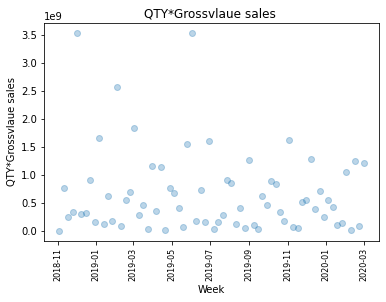

In [11]:
plt.scatter(weekly.Date , weekly.Qty_Value , alpha=0.3,cmap='viridis')
plt.xlabel("Week")
plt.xticks (rotation='vertical', size=8)
plt.ylabel("QTY*Grossvlaue sales")
plt.title("QTY*Grossvlaue sales ")
plt.rcParams['figure.figsize'] = [15, 5]
plt.show()

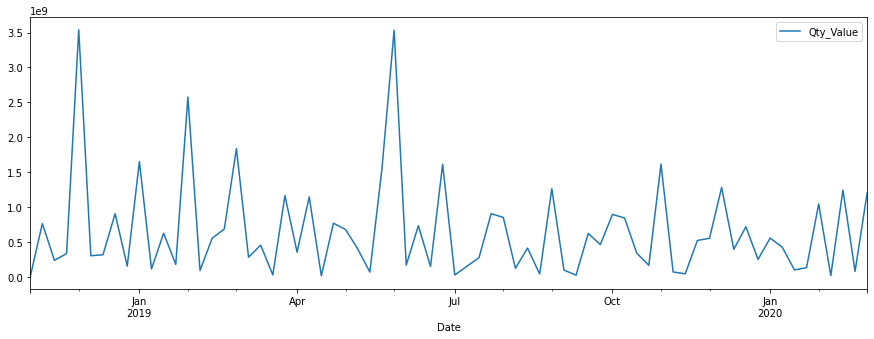

In [12]:
weekly.plot(kind = 'line', x = 'Date', y = 'Qty_Value')
plt.show()

In [13]:
# remove z score > 3 
Sec_invoice_Agg = weekly[(np.abs(stats.zscore(weekly["Qty_Value"])) < 3)]

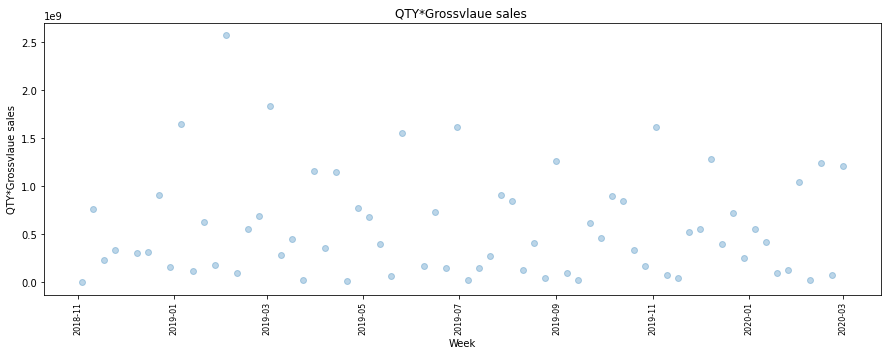

In [14]:
plt.scatter(Sec_invoice_Agg.Date , Sec_invoice_Agg.Qty_Value , alpha=0.3,cmap='viridis')
plt.xlabel("Week")
plt.xticks (rotation='vertical', size=8)
plt.ylabel("QTY*Grossvlaue sales")
plt.title("QTY*Grossvlaue sales ")
plt.rcParams['figure.figsize'] = [15, 5]
plt.show()

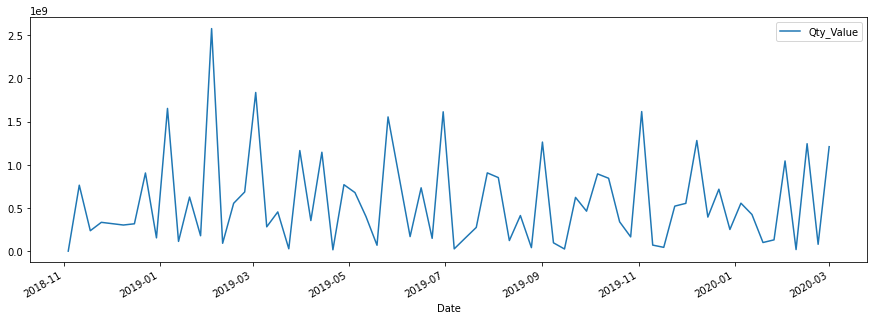

In [15]:
Sec_invoice_Agg.plot(kind = 'line', x = 'Date', y = 'Qty_Value')
plt.show()

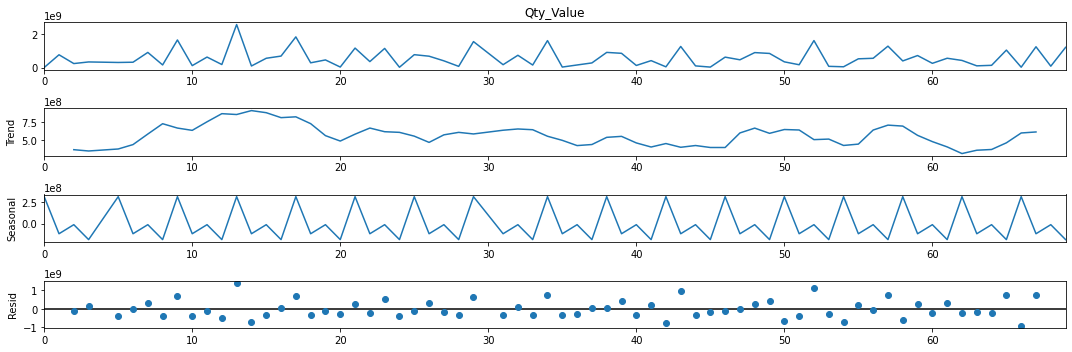

In [16]:
decomposition = seasonal_decompose(Sec_invoice_Agg['Qty_Value'], period =4)
decomposition.plot()
plt.show()

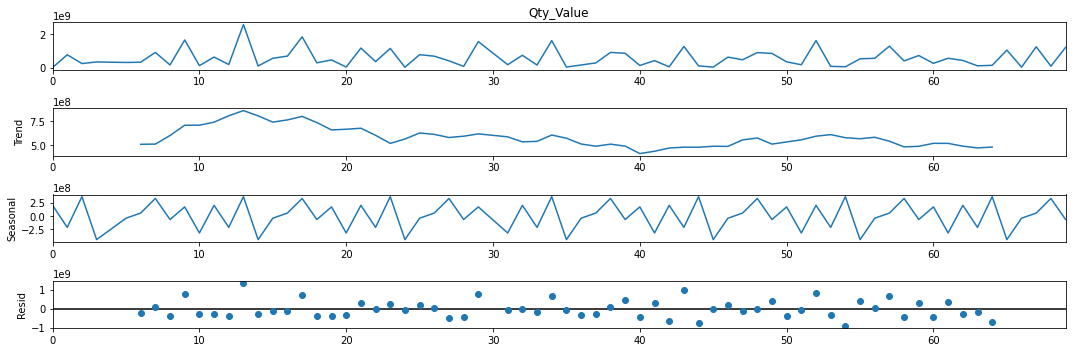

In [17]:
decomposition = seasonal_decompose(Sec_invoice_Agg['Qty_Value'], period =10)
decomposition.plot()
plt.show()

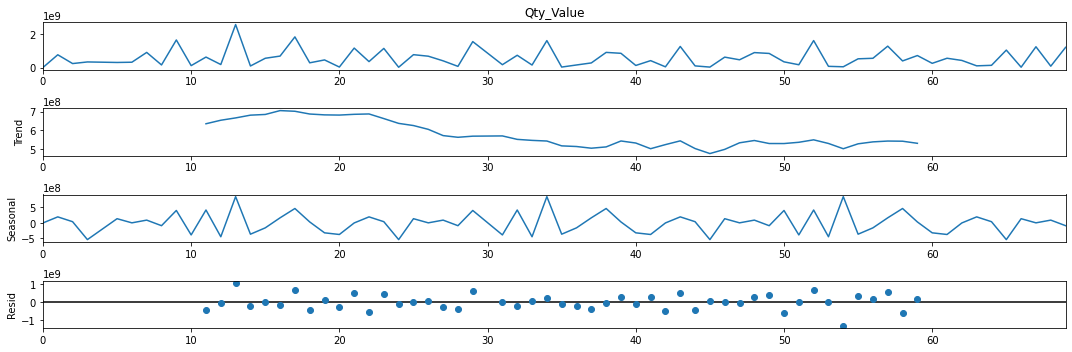

In [18]:
decomposition = seasonal_decompose(Sec_invoice_Agg['Qty_Value'], period =20)
decomposition.plot()
plt.show()

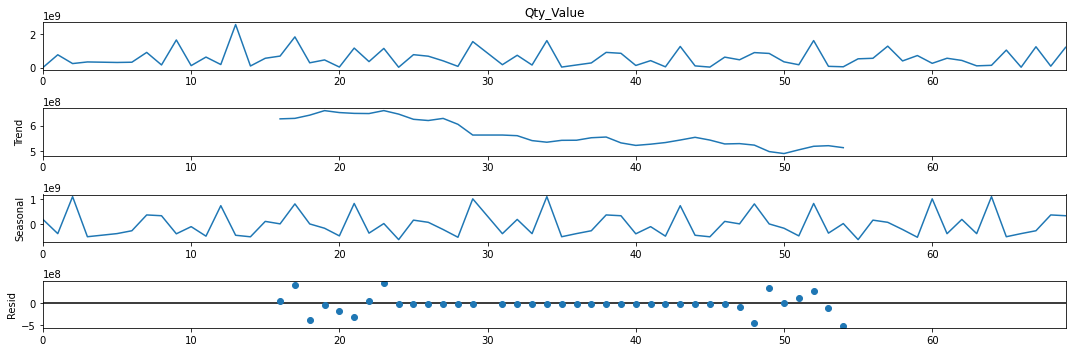

In [19]:
decomposition = seasonal_decompose(Sec_invoice_Agg['Qty_Value'], period =30)
decomposition.plot()
plt.show()

In [20]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(Sec_invoice_Agg['Qty_Value'])
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Statistic                 -3.978140
p-value                         0.001529
#Lags Used                      3.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


In [21]:
#create Date Table
def create_date_table2(start='2018-11-04', end='2020-03-01'):
    df = pd.DataFrame({"Date": pd.date_range(start, end)})
    return df

In [22]:
date_table = create_date_table2()

In [23]:
date_table.head(12)

,Date
0,2018-11-04
1,2018-11-05
2,2018-11-06
3,2018-11-07
4,2018-11-08
5,2018-11-09
6,2018-11-10
7,2018-11-11
8,2018-11-12
9,2018-11-13


In [24]:
# keep every 7th row
date_table = date_table.iloc[::7, :]

In [25]:
date_table

,Date
0,2018-11-04
7,2018-11-11
14,2018-11-18
21,2018-11-25
28,2018-12-02
...,...
455,2020-02-02
462,2020-02-09
469,2020-02-16
476,2020-02-23


In [26]:
#left Join with Weekly date table
Sec_inv_mis = date_table.merge(Sec_invoice_Agg, on='Date', how='left')

In [27]:
Sec_inv_mis.head(10)

,Date,Qty_Value
0,2018-11-04,1.334272e+06
1,2018-11-11,7.642306e+08
2,2018-11-18,2.375291e+08
3,2018-11-25,3.345882e+08
4,2018-12-02,NaN
5,2018-12-09,3.034657e+08
6,2018-12-16,3.177796e+08
7,2018-12-23,9.055233e+08
8,2018-12-30,1.549992e+08
9,2019-01-06,1.652532e+09


In [28]:
#fill missing value with mean
Sec_inv_mis.fillna({"Qty_Value":Sec_inv_mis['Qty_Value'].mean().round(1)}, inplace=True)

In [29]:
Sec_inv_grp = Sec_inv_mis.sort_index()
Sec_inv_grp.head(10)

,Date,Qty_Value
0,2018-11-04,1.334272e+06
1,2018-11-11,7.642306e+08
2,2018-11-18,2.375291e+08
3,2018-11-25,3.345882e+08
4,2018-12-02,5.692662e+08
5,2018-12-09,3.034657e+08
6,2018-12-16,3.177796e+08
7,2018-12-23,9.055233e+08
8,2018-12-30,1.549992e+08
9,2019-01-06,1.652532e+09


In [30]:
#Pro1_inv_Nor_Sm = Pro1_inv_Nor_Sm.reset_index()
train = Sec_inv_grp.loc[Sec_inv_grp['Date'] <= "2019-11-30"]
train = train.set_index('Date')
test = Sec_inv_grp.loc[Sec_inv_grp['Date'] > "2019-11-30"]
test = test.set_index('Date')

In [31]:
from pmdarima import auto_arima
model = auto_arima(train.Qty_Value, test='adf', trace=True, start_p=1,start_q=1 ,max_p=4,max_q=4 
                   ,suppress_warnings=True,stepwise=False,seasonal=False)
results = model.fit(train.Qty_Value)
results.summary()

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2455.466, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2454.300, Time=0.01 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=2450.643, Time=0.03 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=2449.098, Time=0.05 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=2434.024, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2450.742, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2427.759, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2418.606, Time=0.06 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=2419.381, Time=0.08 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=2417.755, Time=0.15 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=2439.463, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2422.937, Time=0.06 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=2418.812, Time=0.11 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=2437.984, Time=0.02 sec
 ARIMA(3,0,1)(0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   56
Model:               SARIMAX(4, 0, 1)   Log Likelihood               -1198.499
Date:                Sun, 17 Apr 2022   AIC                           2408.998
Time:                        20:12:15   BIC                           2421.151
Sample:                             0   HQIC                          2413.710
                                 - 56                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2180      0.231      0.943      0.346      -0.235       0.671
ar.L2          0.1267      0.208      0.609      0.543      -0.281       0.535
ar.L3          0.0765      0.182      0.420      0.675      -0.281       0.434
ar.L4          0.5508      0.151      3.660      0.000       0.256       0.846
ma.L1         -0.5820      0.227     -2.559      0.010      -1.028      -0.136
sigma2      2.694e+17   1.22e-18   2.21e+35      0.000    2.69e+17    2.69e+17
===================================================================================
Ljung-Box (L1) (Q):                   0.25   Jarque-Bera (JB):                 5.93
Prob(Q):                              0.62   Prob(JB):                         0.05
Heteroskedasticity (H):               0.70   Skew:                             0.72
Prob(H) (two-sided):                  0.44   Kurtosis:                         3.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.19e+50. Standard errors may be unstable.
"""

In [32]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(train['Qty_Value'],
                order=(4,0,1),seasonal_order=(0,0,0,0))
results = model.fit(disp=0)
results.summary()

c:\users\amila.h\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
c:\users\amila.h\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Qty_Value   No. Observations:                   56
Model:               SARIMAX(4, 0, 1)   Log Likelihood               -1198.499
Date:                Sun, 17 Apr 2022   AIC                           2408.998
Time:                        20:12:27   BIC                           2421.151
Sample:                    11-04-2018   HQIC                          2413.710
                         - 11-24-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2180      0.231      0.943      0.346      -0.235       0.671
ar.L2          0.1267      0.208      0.609      0.543      -0.281       0.535
ar.L3          0.0765      0.182      0.420      0.675      -0.281       0.434
ar.L4          0.5508      0.151      3.660      0.000       0.256       0.846
ma.L1         -0.5820      0.227     -2.559      0.010      -1.028      -0.136
sigma2      2.694e+17   1.22e-18   2.21e+35      0.000    2.69e+17    2.69e+17
===================================================================================
Ljung-Box (L1) (Q):                   0.25   Jarque-Bera (JB):                 5.93
Prob(Q):                              0.62   Prob(JB):                         0.05
Heteroskedasticity (H):               0.70   Skew:                             0.72
Prob(H) (two-sided):                  0.44   Kurtosis:                         3.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.19e+50. Standard errors may be unstable.
"""

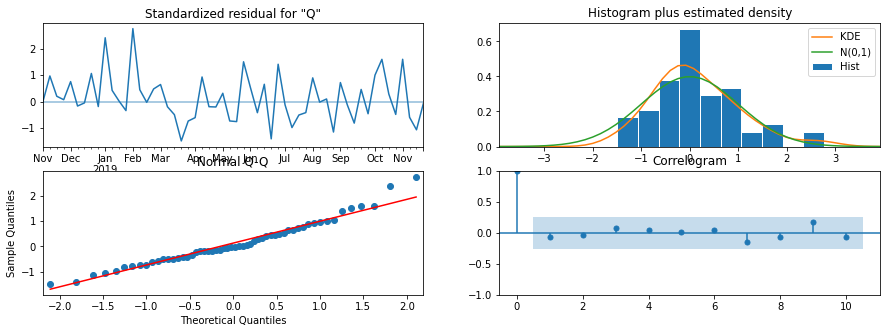

In [33]:
results.plot_diagnostics()
plt.show()

### Rolling Forecast ARIMA Model

In [34]:
X = Sec_inv_grp.Qty_Value.values
data_Size = int(len(Sec_inv_grp.Qty_Value.values))
train_size = int(len(train.Qty_Value.values))


X_train, X_test = X[0:train_size], X[train_size:data_Size]
history = [x for x in X_train]
predictions = []

In [35]:
for t in range(len(test)):
    model = SARIMAX(history, order=(4,0,1),seasonal_order=(0,0,0,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = X_test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))

In [36]:
# get array data to DF with date index
Prd_Results = pd.DataFrame(data = predictions, columns = ['Qty_Value'], index = test.index.copy())

In [37]:
from sklearn.metrics import mean_squared_error
from math import sqrt
mse = mean_squared_error(test, Prd_Results)
rmse = sqrt(mse)
print('RMSE: %f' % rmse)

RMSE: 484123502.114659


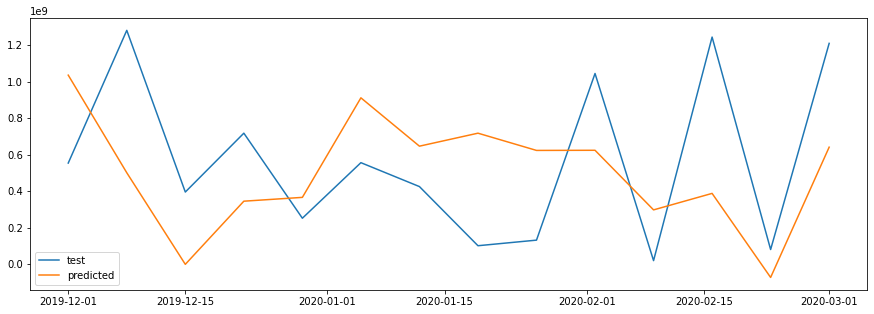

In [38]:
plt.plot(test)
plt.plot(Prd_Results)
plt.legend(['test', 'predicted'])

In [43]:
#Aggregate data into weekly sum
sample_price=Sec_invoice_All[['Date','UnitPrice']]
weekly_price=sample_price.drop_duplicates()

In [44]:
#get week start date time
weekly_price['week_start'] = weekly_price['Date'] - pd.offsets.Week(weekday=6)

<ipython-input-44-2c32a8b92fed>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weekly_price['week_start'] = weekly_price['Date'] - pd.offsets.Week(weekday=6)


In [45]:
#convert week start date time to date
weekly_price['week_start'] = pd.to_datetime(weekly_price['week_start']).dt.date

<ipython-input-45-70b2120873e8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weekly_price['week_start'] = pd.to_datetime(weekly_price['week_start']).dt.date


In [46]:
weekly_price=weekly_price[['week_start','UnitPrice']]
weekly_price = weekly_price.drop_duplicates()
weekly_price = weekly_price.sort_values(by="week_start")

In [47]:
weekly_price

,week_start,UnitPrice
177,2018-10-28,238.7
309,2018-10-28,216.7
272,2018-11-04,216.7
503,2018-11-04,238.7
1808,2018-11-04,206.1
...,...,...
558856,2020-02-16,264.0
601788,2020-02-23,206.1
601786,2020-02-23,263.2
566196,2020-02-23,264.0
